# Preparação do Ambiente

In [42]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt
import gymnasium as gym

In [43]:
def moving_average(rewards, window_size=10):
    n = len(rewards)
    grouped_means = [np.mean(rewards[i:i+window_size]) for i in range(0, n, window_size)]
    grouped_indices = [i for i in range(0, n, window_size)]
    return grouped_indices, grouped_means

In [44]:
def plot_rewards(train_rewards, test_rewards=None, title=None, max_reward=None, window_size=10):
    if test_rewards is not None:
        fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    else:
        fig, axes = plt.subplots(1, 1, figsize=(10, 5))
        axes = [axes]

    # TRAINING
    axes[0].plot(train_rewards, label='Reward (puro)', color='skyblue', alpha=0.6)
    train_x, train_avg = moving_average(train_rewards, window_size)
    axes[0].plot(train_x, train_avg, label=f'Média a cada {window_size}', color='orange')
    axes[0].set_title("Training")
    axes[0].set_xlabel("Episodes")
    axes[0].set_ylabel("Reward")

    if max_reward is not None:
        axes[0].axhline(max_reward, color='red', linestyle='--', label='Max Reward')

    axes[0].legend()

    # TESTING
    if test_rewards is not None:
        axes[1].plot(test_rewards, label='Reward (puro)', color='skyblue', alpha=0.6)
        test_x, test_avg = moving_average(test_rewards, window_size)
        axes[1].plot(test_x, test_avg, label=f'Média a cada {window_size}', color='orange')
        axes[1].set_title("Testing")
        axes[1].set_xlabel("Episodes")
        axes[1].set_ylabel("Reward")

        if max_reward is not None:
            axes[1].axhline(max_reward, color='red', linestyle='--', label='Max Reward')

        axes[1].legend()

    if title:
        fig.suptitle(title)

    plt.tight_layout()
    plt.show()

In [45]:
def plot_losses(losses, title=None):
   fig, axes = plt.subplots(1, 1, figsize=(10, 5))
   axes.plot(losses)
   axes.set_title("Losses" if title is None else title)
   axes.set_xlabel("Episodes")
   axes.set_ylabel("Loss")
   plt.show()

# Prioritized Experience Replay (PER)

In [46]:
class SumTree:
    def __init__(self, capacity: int):
        self.capacity = capacity
        # A árvore tem (2 * capacity - 1) nós no total.
        self.tree = np.zeros(2 * capacity - 1)
        self.data_pointer = 0

    def add(self, priority: float, data_index: int):
        """ Adiciona uma nova prioridade na árvore. """
        tree_index = self.data_pointer + self.capacity - 1
        
        self.update(tree_index, priority)
        
        self.data_pointer = (self.data_pointer + 1) % self.capacity

    def update(self, tree_index: int, priority: float):
        """ Atualiza a prioridade de um nó e propaga a mudança para cima. """
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        
        # Propaga a mudança para a raiz
        while tree_index != 0:
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change

    def get_leaf(self, value: float) -> (int, float, int):
        """ Encontra a amostra (índice da árvore, prioridade, índice do dado) para um dado valor. """
        parent_index = 0
        while True:
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            
            # Chegou em uma folha
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            else:
                if value <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    value -= self.tree[left_child_index]
                    parent_index = right_child_index
        
        data_index = leaf_index - self.capacity + 1
        return leaf_index, self.tree[leaf_index], data_index

    @property
    def total_priority(self) -> float:
        """ Retorna a prioridade total (valor na raiz). """
        return self.tree[0]

In [47]:
class PrioritizedReplayBuffer:
   def __init__(self, capacity: int, observation_dim, alpha: float = 0.6):
      self._alpha = alpha
      self._capacity = capacity
      self._size = 0
      self._index = 0
      
      # Estruturas de dados
      self._memory = np.empty(capacity, dtype=object)
      self._tree = SumTree(capacity)
      
      # Constantes
      self.PER_e = 0.01
      self.max_priority = 1.0

   def __len__(self):
      return self._size

   def store(self, state, action, reward, next_state, done):
      """ Armazena uma nova transição e dá a ela a prioridade máxima. """
      experience = (state, action, reward, next_state, done)
      self._memory[self._index] = experience
      
      # Adiciona a prioridade na SumTree
      self._tree.add(self.max_priority, self._index)
      
      # Atualiza os ponteiros
      self._index = (self._index + 1) % self._capacity
      self._size = min(self._size + 1, self._capacity)

   def sample(self, batch_size: int, beta: float = 0.4):
      """ Amostra um batch de transições usando a SumTree. """
      assert self._size >= batch_size, "Buffer tem menos amostras que o batch_size"

      batch_indices = np.empty(batch_size, dtype=np.int32)
      tree_indices = np.empty(batch_size, dtype=np.int32)
      priorities = np.empty(batch_size, dtype=np.float32)

      segment = self._tree.total_priority / batch_size
      
      for i in range(batch_size):
         a = segment * i
         b = segment * (i + 1)
         value = np.random.uniform(a, b)
         tree_idx, priority, data_idx = self._tree.get_leaf(value)
         
         priorities[i] = priority
         batch_indices[i] = data_idx
         tree_indices[i] = tree_idx

      # Calcula os pesos de Importance Sampling (IS)
      sampling_probabilities = priorities / self._tree.total_priority
      weights = np.power(self._size * sampling_probabilities, -beta)
      weights /= weights.max() # Normaliza para estabilidade

      # Extrai os dados das transições
      states, actions, rewards, next_states, dones = zip(*self._memory[batch_indices])
      
      return (
         np.array(states),
         np.array(actions),
         np.array(rewards, dtype=np.float32),
         np.array(next_states),
         np.array(dones, dtype=np.int32),
         weights.astype(np.float32),
         tree_indices 
      )

   def update_priorities(self, tree_indices: np.ndarray, errors: np.ndarray):
      """ Atualiza as prioridades na SumTree após um passo de aprendizado. """
      priorities = (np.abs(errors) + self.PER_e) ** self._alpha
      
      for ti, p in zip(tree_indices, priorities):
         self._tree.update(ti, p)
      
      self.max_priority = max(self.max_priority, np.max(priorities))

# Definição da Rede

In [48]:
class DQN(nn.Module):
   def __init__(self, observation_shape, action_shape):
      super(DQN, self).__init__()
      self.fc1 = nn.Linear(observation_shape[0], 128)
      self.fc2 = nn.Linear(128, 128)
      self.fc3 = nn.Linear(128, action_shape)
   
   def forward(self, x):
      x = torch.relu(self.fc1(x))
      x = torch.relu(self.fc2(x))
      x = self.fc3(x)
      return x

# Definição do Agente

In [49]:
class PrioritizedDQNAgent:
   def __init__(self, env,
                epsilon=1,
                alpha=1e-3,
                gamma=0.999,
                epsilon_decay=0.998,
                epsilon_min=0.01,
                batch_size=64,
                replay_buffer_size=100000,
                beta=0.4,
                beta_decay=1e-5):
      self.epsilon = epsilon
      self.alpha = alpha
      self.gamma = gamma
      self.epsilon_decay = epsilon_decay
      self.epsilon_min = epsilon_min
      self.batch_size = batch_size
      self.beta = beta
      self.beta_decay = beta_decay
      
      self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")         
      self.env = env
      
      self.dqn = DQN(env.observation_space.shape, env.action_space.n).to(self.device)
      self.dqn_target = DQN(env.observation_space.shape, env.action_space.n).to(self.device)

      self.dqn_target.load_state_dict(self.dqn.state_dict())
      self.dqn_target.eval()
      
      self.replay = PrioritizedReplayBuffer(replay_buffer_size, env.observation_space.shape[0])
      
      self.optimizer = optim.Adam(self.dqn.parameters(), lr=alpha)
      self.loss = nn.SmoothL1Loss(reduction='none')
   
   def _update_dqn_target(self):
      self.dqn_target.load_state_dict(self.dqn.state_dict())

   def act(self, state):
      self.dqn.eval()
      
      if np.random.rand() < self.epsilon:
         return self.env.action_space.sample()
      
      with torch.no_grad():
         state = torch.tensor(state, dtype=torch.float32).to(self.device)
         action = self.dqn(state).argmax(dim=-1).item()
      
      return action
   
   def update(self):
      self.dqn.train()
      
      states, actions, rewards, next_states, dones, weights, indices = self.replay.sample(self.batch_size, self.beta)
      
      states = torch.as_tensor(states).to(self.device)
      actions = torch.as_tensor(actions).to(self.device).unsqueeze(-1)
      rewards = torch.as_tensor(rewards).to(self.device).unsqueeze(-1)
      next_states = torch.as_tensor(next_states).to(self.device)
      dones = torch.as_tensor(dones).to(self.device).unsqueeze(-1)
      weights = torch.as_tensor(weights).to(self.device).unsqueeze(-1)
      
      q_eval = self.dqn(states).gather(-1, actions.long())
      
      with torch.no_grad():
         next_actions = self.dqn(next_states).argmax(dim=1, keepdim=True)
         q_next = self.dqn_target(next_states).gather(1, next_actions)
         q_target = rewards + self.gamma * q_next * (1 - dones)
      
      losses = self.loss(q_eval, q_target)
      loss = torch.mean(losses * weights)

      self.optimizer.zero_grad()
      loss.backward()
      self.optimizer.step()
      
      td_errors = (q_eval - q_target).detach().cpu().numpy().squeeze()
      self.replay.update_priorities(indices, td_errors)
      
      self.beta = min(1, self.beta + self.beta_decay)
      
      return loss.item()
         
   def train(self, episodes, verbose=False):
      progress = tqdm(range(1, episodes + 1), desc="Training", disable=not verbose)
      rewards = []
      losses = []
            
      for episode in progress:
         state, _ = self.env.reset()
         episode_reward = 0
         done = False
         
         while not done:
            action = self.act(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            self.replay.store(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            
            if len(self.replay) > self.batch_size:
               losses.append(self.update())
         
         if episode % 50 == 0:
            self._update_dqn_target()
         
         self.epsilon = max(self.epsilon * self.epsilon_decay, self.epsilon_min)
         
         rewards.append(episode_reward)
         progress.set_postfix({ "Reward": episode_reward, "Epsilon": self.epsilon })
         
      return rewards, losses
   
   def evaluate(self, episodes, verbose=False):
      progress = tqdm(range(1, episodes + 1), desc="Evaluating", disable=not verbose)
      rewards = []
      
      epsilon_real = self.epsilon
      self.epsilon = 0
      
      self.dqn.eval()
      
      for episode in progress:
         state, _ = self.env.reset()
         episode_reward = 0
         done = False
         
         while not done:
            action = self.act(state)
            next_state, reward, terminated, truncated, _ = self.env.step(action)
            done = terminated or truncated
            state = next_state
            episode_reward += reward
            
         rewards.append(episode_reward)
         progress.set_postfix({ "Reward": episode_reward })
      
      self.epsilon = epsilon_real
         
      return rewards

   def save(self, path):
      torch.save(self.dqn.state_dict(), path)
   
   def load(self, path):
      self.dqn.load_state_dict(torch.load(path))

# Ambientes

In [50]:
envs = [
    ("CartPole-v1",       "CartPole",       "cartpole_per.pt",      500),
    ("Acrobot-v1",        "Acrobot",        "acrobot_per.pt",       0),
    ("MountainCar-v0",    "MountainCar",    "mountaincar_per.pt",   -50),
    ("LunarLander-v3",    "LunarLander",    "lunarlander_per.pt",   200),
]

Training CartPole...


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 37.23it/s, Reward=234]


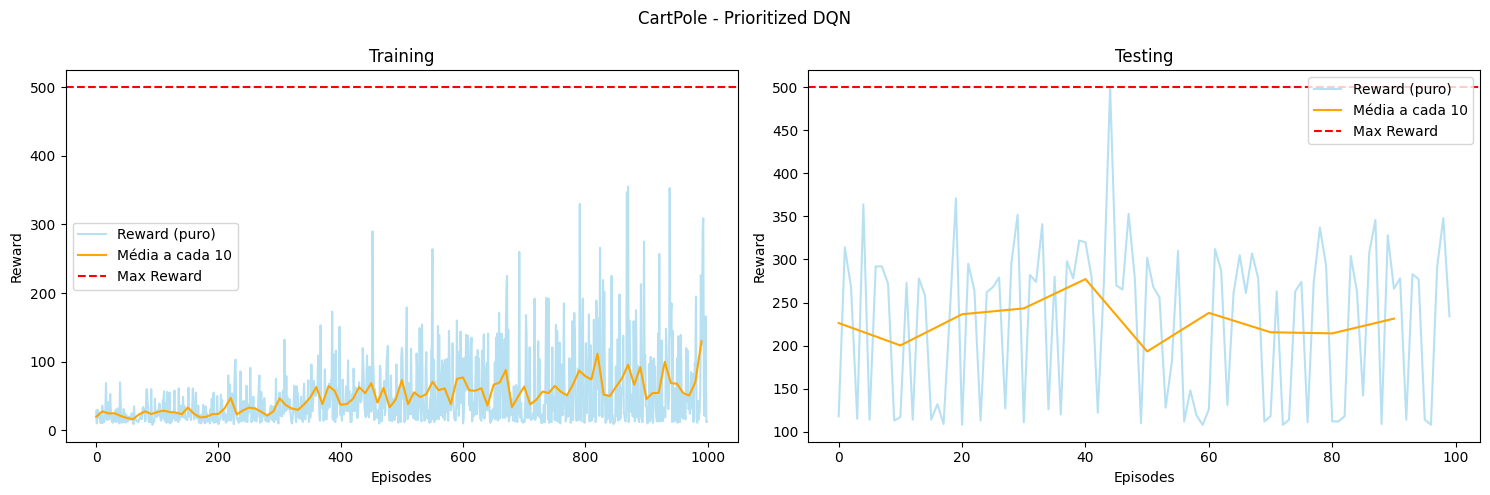

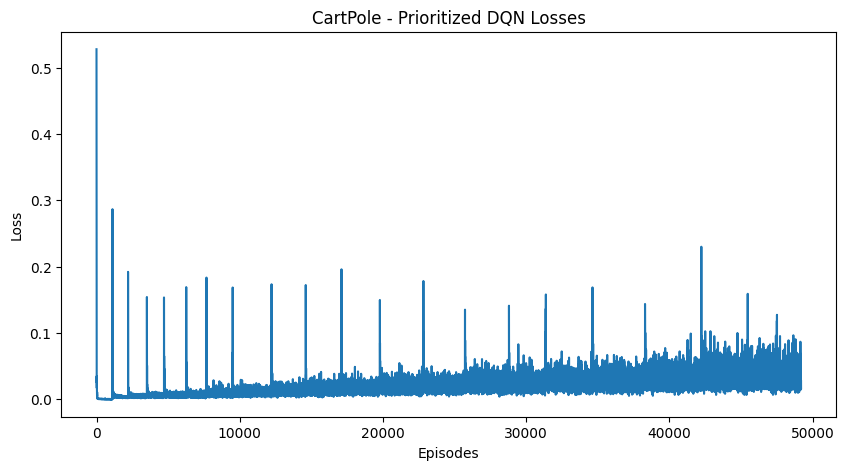

Done!

Training Acrobot...


Evaluating: 100%|██████████| 100/100 [00:09<00:00, 10.60it/s, Reward=-500]


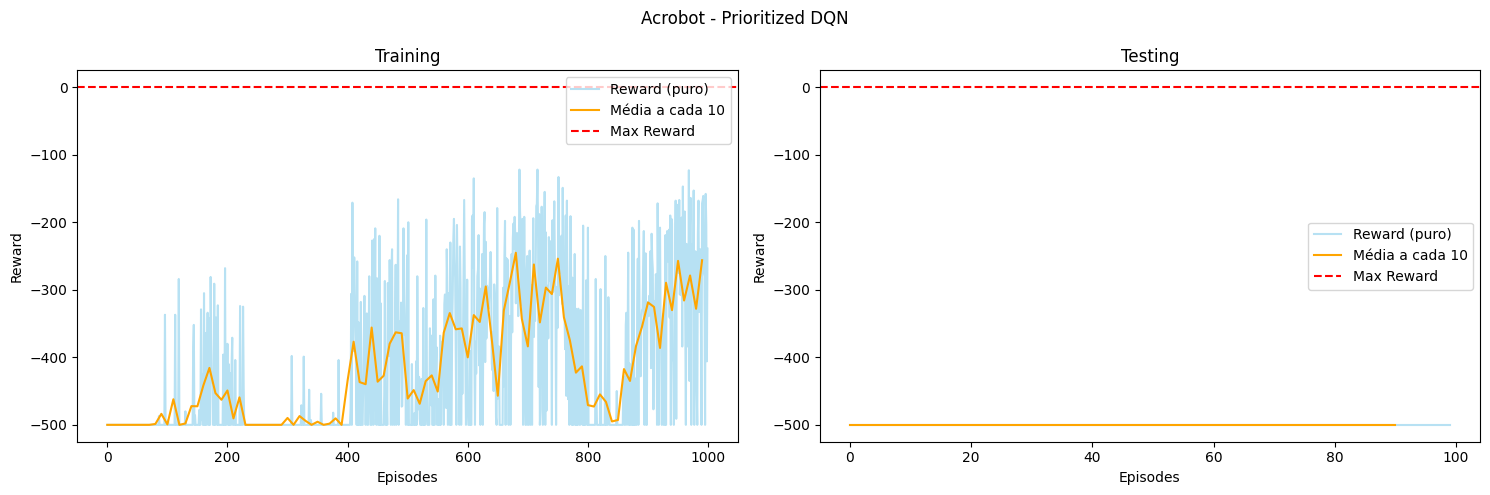

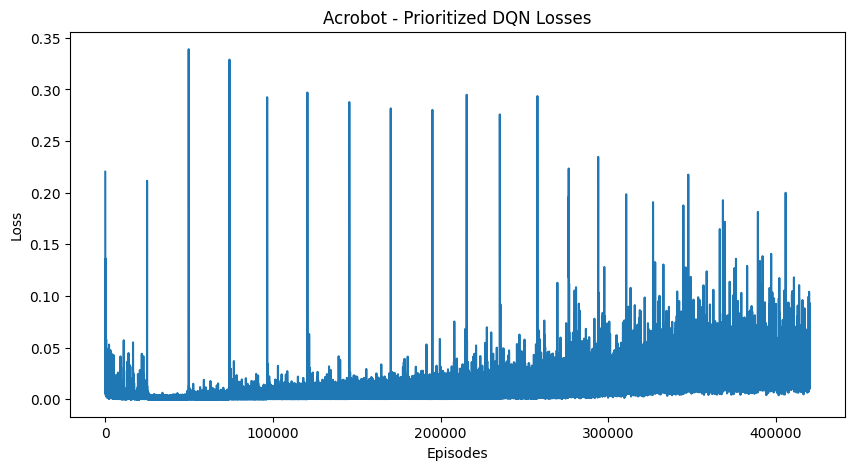

Done!

Training MountainCar...


Evaluating: 100%|██████████| 100/100 [00:02<00:00, 41.66it/s, Reward=-200]


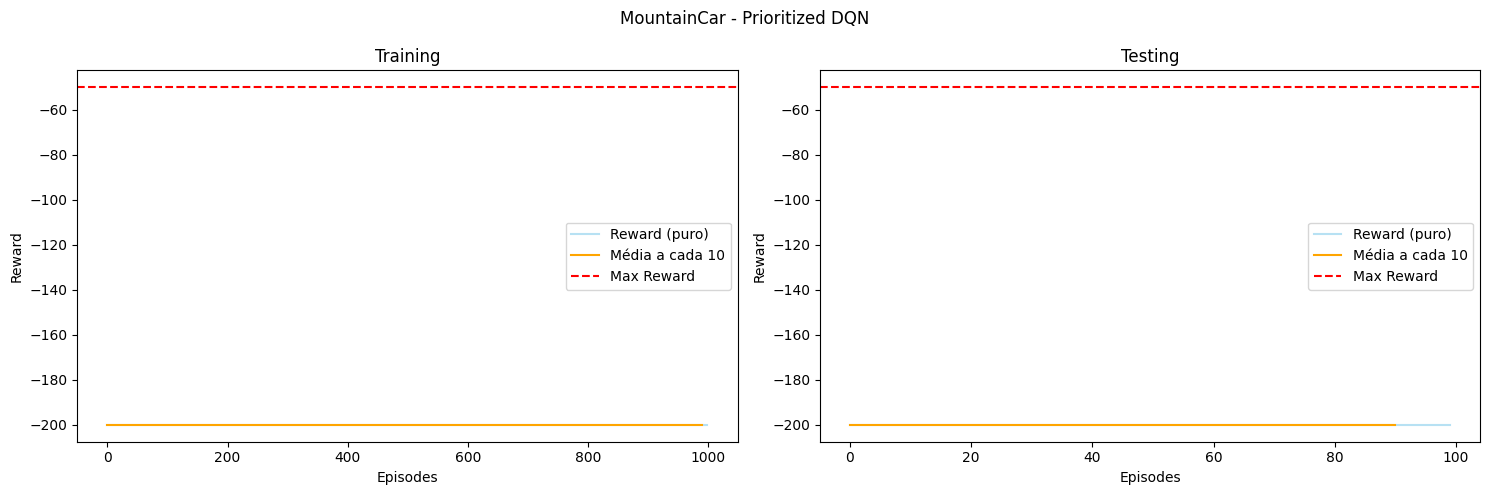

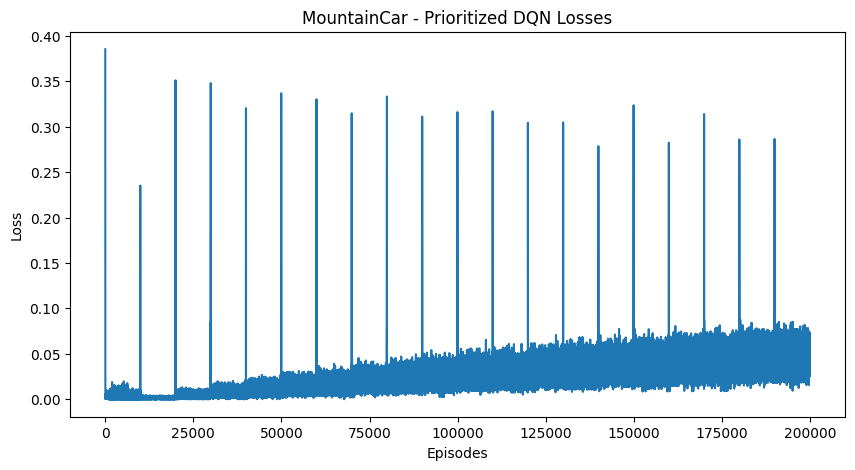

Done!

Training LunarLander...


Evaluating: 100%|██████████| 100/100 [00:06<00:00, 15.84it/s, Reward=82.2]


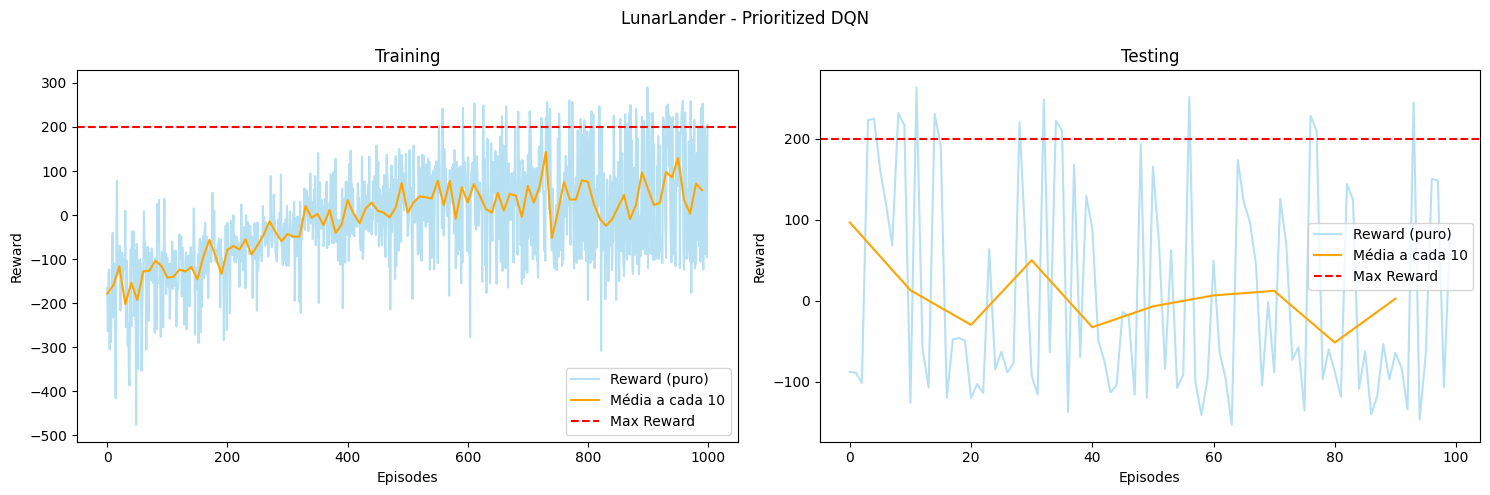

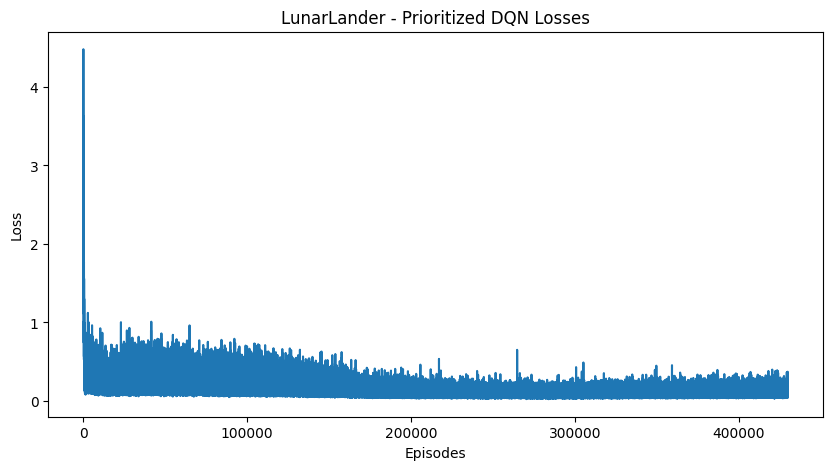

Done!



In [51]:
for env_name, env_title, path, max_reward in envs:
   print(f"Training {env_title}...")
   
   env = gym.make(env_name)
   agent = PrioritizedDQNAgent(env, beta_decay=(1 - 0.4) / 1000)
   
   train_rewards, losses = agent.train(1000, verbose=True)
   test_rewards = agent.evaluate(100, verbose=True)
   
   agent.save(f'checkpoint/{path}')
   
   plot_rewards(train_rewards, test_rewards, f"{env_title} - Prioritized DQN", max_reward=max_reward)
      
   print("Done!\n")